In [1]:
# toogle view
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
#Import modules #Run this once
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
#directories
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
print('The working directory is parentdir: %s' %parentdir)

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis


# Real on-off histogram

***At 75 mV (Point_15_75mV_S106)***
<img src="../temp/Point_15_75mV_S106.png" alt="Drawing" style="width: 600px;"/>

<img src="../temp/Point_15_75mV_S106.png style="width: 200px;"/">

# Simulation

***Parameters for simulation***

The on off times should follow the relation:

$$E = E_0 + \frac{k_BT}{ne}log_{10}(\frac{\tau_{on}}{\tau_{off}})$$

We will simulate time trace at $75~mV$ with $E_0 = 5mV$

From expreimental analysis: $\tau_{off} = 0.25~s$ and $\tau_{on} = 0.02~s$

But we can also estimate the expected value  as follow of $\tau_{on}$ instead of directly giving the value.

In [3]:
E=75; E0=0; toff=0.25; # give potential value in mV and time in seconds
ton = toff*(10**((E0-E)/59));
print('tov value is:', ton)

tov value is: 0.013389167294267248


***Run the function here***

In [2]:
%run simulation.py

## simulate_on_off_time

numpoint: 3802


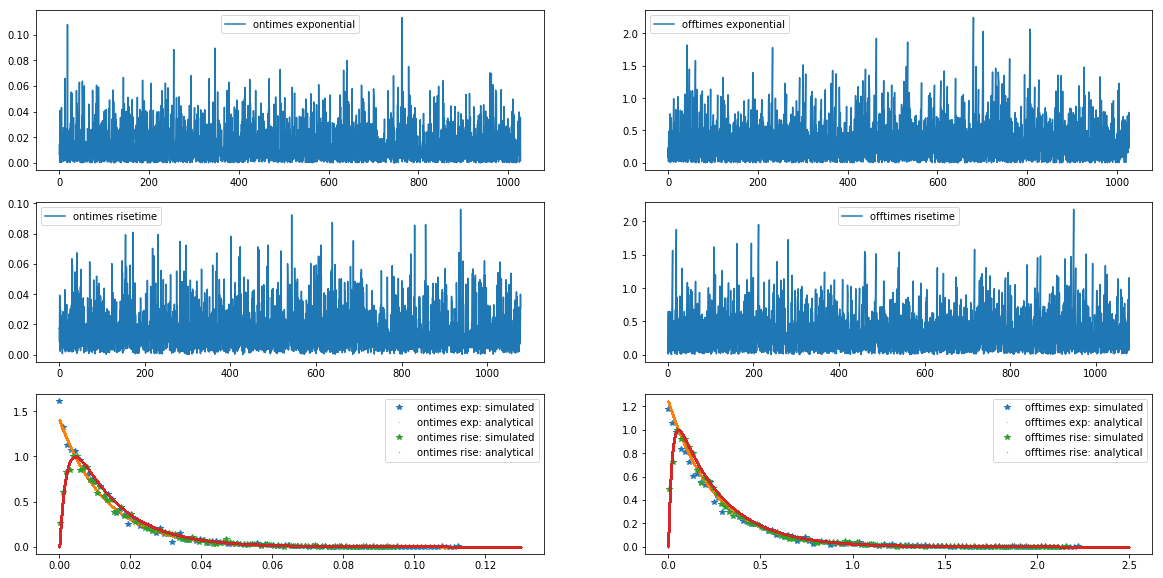

In [4]:
out = simulate_on_off_times(ton1=0.013, ton2=0.002, toff1=0.250,
                        toff2=0.02, time_len=1000, plotting=True);
[ontimes_exp_1, ontimes_exp_rise, offtimes_exp_1, offtimes_exp_rise] = out

In [18]:
ontimes_exp_1

array([0, 0, 0, ..., 0, 0, 0])

## photonstamps from on-off times and counts

In [6]:
ontimes=ontimes_exp_1;
offtimes = offtimes_exp_rise;
timestamps, timestamps_marker = timestamps_from_onofftrace(ontimes, offtimes,
                                                           i_on_mu=2500, i_off_mu=200);

(0, 10)

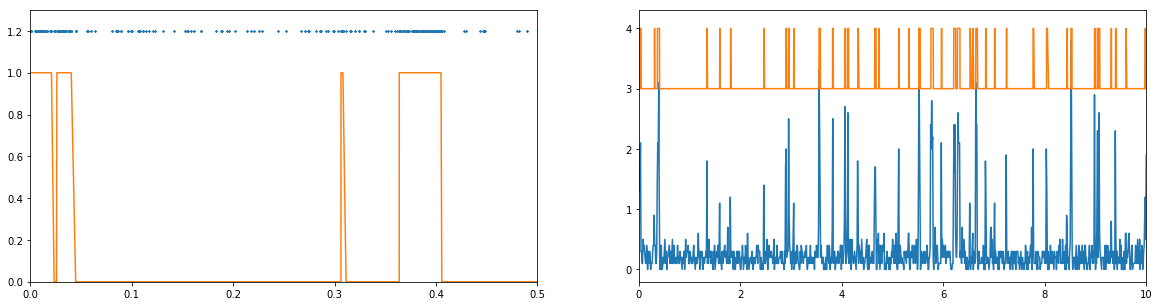

In [7]:
#plotting
bintime = 10e-3;
bins = np.int((max(timestamps) - min(timestamps))/bintime)
hist, trace = np.histogram(timestamps, bins=bins)
# plt.plot(timestamps, np.ones_like(timestamps), '*',ms=5);
fig = plt.figure(figsize=(20, 5));
nrows=1; ncols=2;
ax00 = plt.subplot2grid((nrows, ncols), (0,0))
ax01 = plt.subplot2grid((nrows, ncols), (0,1))
ax00.plot(timestamps, 0.2+np.ones_like(timestamps), '*',ms=2);
ax00.plot(timestamps, timestamps_marker);
ax00.set_xlim(0, 0.5)
ax00.set_ylim(0, 1.3)
ax01.plot(trace[:-1], hist*1e-3/bintime)
ax01.plot(timestamps, 3+timestamps_marker)
ax01.set_xlim(0, 10)

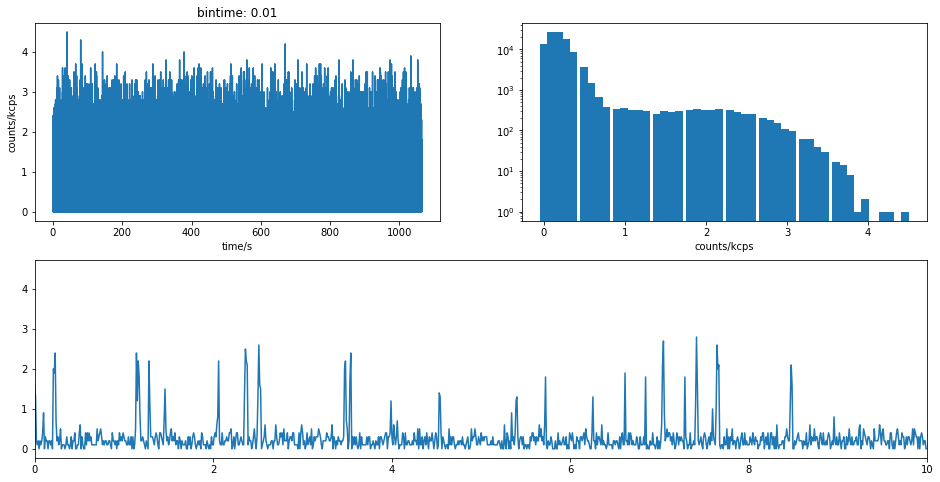

In [41]:
%run simulation.py
intensity_fit(timestamps, bintime=10e-3)

## nanotimes

(4.5, 8)

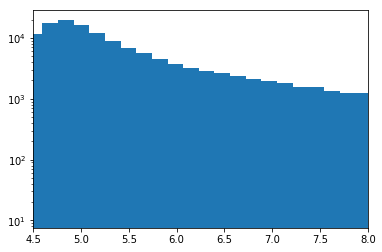

In [122]:
%run simulation.py
# timestamps, timestamps_marker, nanotimes = timestamps_from_onofftrace(ontimes, offtimes,
#                                                            i_on_mu=3000, i_off_mu=200);


# hdf5saved = save_simulated_trace(ton1=0.016, ton2=0.002, 
#                                  toff1=0.250, toff2=0.02, 
#                                  i_on_mu=3000, i_off_mu=200, 
#                                  time_len=100);
hdf5saved
hdf5_simulated = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis/data_simulated/20180117_2118_ton0.016toff0.25timelen400bg200sig3000.hdf5'
h5 = h5py.File(hdf5_simulated, 'r')
timestamps = h5['onexp_offexp']['timestamps'][...]
nanotimes = h5['onexp_offexp']['nanotimes'][...]
# t_on_sim = h5['onexp_offexp']['ontimes_exp'][...]
# t_off_sim = h5['onexp_offexp']['offtimes_exp'][...]
h5.close()
plt.hist(nanotimes*1e9, bins=200);
plt.yscale('log')
plt.xlim(4.5, 8)

## FCS and fitting test

In [180]:
%run pycorrelate.py
simulatedhdf5 = 'data_simulated/20180111_1416_ton0.016toff0.25timelen5000bg200sig3000.hdf5';
h5 = h5py.File(simulatedhdf5, 'r')
timestamps = h5['onexp_offexp']['timestamps'][...]
ontimes = h5['onexp_offexp']['ontimes_exp'][...]
bin_lags = make_loglags(-6, 0, 10)
Gn = normalize_G(timestamps, timestamps, bin_lags)
Gn = np.hstack((Gn[:1], Gn))-1
h5.close()
#========fitting and plotting========
def FCS_mono_fit(bin_lags, Gn, tmin=5.0e-6,tmax=1.0e3,
                signal=3.0e3, bg=2.0e2, bg_corr=True):
    xdata=bin_lags;
    mask = np.logical_and(xdata >= tmin, xdata <= tmax)
    xdata = xdata[mask]
    ydata=Gn[mask];
    correction_BG = ((signal+bg)/signal)**2
    if bg_corr:
        ydata= ((ydata)*correction_BG)
    def mono_exp(x, A, t_ac):
        return A*np.exp(-x/t_ac)
    from lmfit import Model
    gmodel = Model(mono_exp)
    gmodel.set_param_hint('A', value=1)#, value=1, min=0.05, max=100
    gmodel.set_param_hint('t_ac', value=0.005)#, value=0.005, min=1, max=100
    pars = gmodel.make_params()
    result = gmodel.fit(ydata, pars, x=xdata)#, A=1, B=1, t_ac=1
    A = result.best_values['A']
    t_ac = result.best_values['t_ac']
    toff = t_ac*(1+A); toff = np.round(toff, 3)
    ton = t_ac*(1+(1/A)); ton = np.round(ton, 3)
    tratio_on_off = ton/toff
#     result.plot()
#     plt.xscale('log')
#     plt.title('\nton:'+str(ton)+' toff:'+str(toff))
    return(ton, toff, tratio_on_off, result)#, t_on_err, t_off_err
ton, toff, tratio_on_off, result = FCS_mono_fit(bin_lags, Gn, bg_corr = True)
ton, toff, tratio_on_off

(0.021999999999999999, 0.081000000000000003, 0.27160493827160492)

### Signal vs fcs extracted times

In [132]:
#
out = simulate_on_off_times(ton1=0.013, ton2=0.002, toff1=0.250,
                        toff2=0.02, time_len=100, plotting=False);
sig_list = [5e2, 1e3, 3e3, 5e3, 1e4, 2e4, 5e4, 1e5]
bg = 200
ton_list = []
ton_list_corr = []
toff_list = []
toff_list_corr = []
for sig in sig_list:
    [ontimes_exp_1, ontimes_exp_rise, offtimes_exp_1, offtimes_exp_rise] = out
    timestamps, timestamps_marker = timestamps_from_onofftrace(ontimes_exp_1, offtimes_exp_1,
                                                               i_on_mu=sig, i_off_mu=200);
    bin_lags = make_loglags(-6, 0, 10)
    Gn = normalize_G(timestamps, timestamps, bin_lags)
    Gn = np.hstack((Gn[:1], Gn))-1
    fig = plt.figure(figsize=(10,5))
    nrows=2; ncols=2;
    ax00 = plt.subplot2grid((nrows, ncols),(0,0), colspan=2)
    ax10 = plt.subplot2grid((nrows, ncols),(1,0))
    ax11 = plt.subplot2grid((nrows, ncols),(1,1))
    #time trace
    bintime = 5e-3;
    bins = int((max(timestamps)-min(timestamps))/bintime)
    binned_trace = np.histogram(timestamps, bins=bins)
    ax00.plot(binned_trace[1][:-1], 1e-3*binned_trace[0]/bintime, 'b', alpha=0.5,
             label='True bright time: ' + str(0.013)+
                    ' s\nTrue dark time:' + str(0.25)+' s');
    ax00.set_xlim(0, 10);
    ax00.set_title('Signal:Noise   '+ str(sig)+":"+str(bg))
    ax00.legend()
    # FCS real
    out_fcs = FCS_mono_fit(bin_lags, Gn, tmin=10.0e-6,tmax=1.0e3,
                    signal=sig, bg=bg, bg_corr=False)
    out_fcs[3].plot_fit(ax=ax10, datafmt='.')
    ax10.set_xscale('log')
    ax10.set_title('Normal \nton:'+str(out_fcs[0])+' toff:'+str(out_fcs[1]))
    ax10.set_xlim(1.0e-5, 1.0e-1)
    ton_list.append(out_fcs[0])
    toff_list.append(out_fcs[1])
    #FCS corrected
    out_fcs = FCS_mono_fit(bin_lags, Gn, tmin=10.0e-6,tmax=1.0e3,
                    signal=sig, bg=bg, bg_corr=True)
    out_fcs[3].plot_fit(ax=ax11, datafmt='.')
    ax11.set_xscale('log')
    ax11.set_title('Corrected \nton:'+str(out_fcs[0])+' toff:'+str(out_fcs[1]))
    ax11.set_xlim(1.0e-5, 1.0e-1)
    ton_list_corr.append(out_fcs[0])
    toff_list_corr.append(out_fcs[1])    
    fig.tight_layout()
    savename = 'data_simulated/figs_simulated/'+'fcs_simulated_trace_sig_'+str(sig)+'.png'
    fig.savefig(savename, dpi=300, frameon=False)

    plt.close('all')

numpoint: 380
numpoint: 380
numpoint: 380
numpoint: 380
numpoint: 380
numpoint: 380
numpoint: 380
numpoint: 380


Text(0.5,1,'off times obtained from FCS curves')

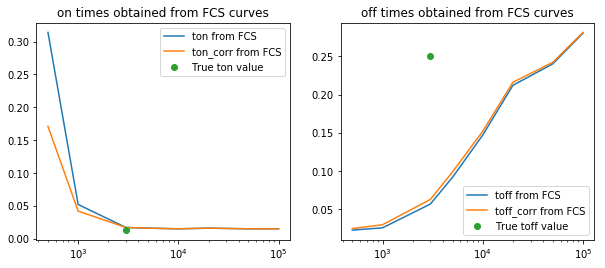

In [153]:
fig = plt.figure(figsize=(10,4))
nrows=1; ncols=2;
ax00=plt.subplot2grid((nrows, ncols),(0,0))
ax01=plt.subplot2grid((nrows, ncols),(0,1))
ax00.plot(sig_list, ton_list, label='ton from FCS')
ax00.plot(sig_list, ton_list_corr, label='ton_corr from FCS')
ax00.plot(3000, 0.013,'o', label='True ton value')
ax00.set_xscale('log')
ax00.legend();
ax00.set_title('on times obtained from FCS curves')

ax01.plot(sig_list, toff_list, label='toff from FCS')
ax01.plot(sig_list, toff_list_corr, label='toff_corr from FCS')
ax01.plot(3000, 0.25,'o', label='True toff value')
ax01.set_xscale('log')
ax01.legend();
ax01.set_title('off times obtained from FCS curves')

## Interphoton data

numpoint: 1140


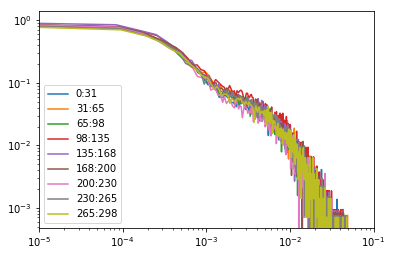

In [183]:
out = simulate_on_off_times(ton1=0.013, ton2=0.002, toff1=0.250,
                        toff2=0.02, time_len=400, plotting=False);
[ontimes_exp_1, ontimes_exp_rise, offtimes_exp_1, offtimes_exp_rise] = out
timestamps, timestamps_marker = timestamps_from_onofftrace(ontimes_exp_1, offtimes_exp_1,
                                                           i_on_mu=3000, i_off_mu=200);
t_mac = timestamps
trange = np.linspace(0, len(t_mac), 10)
trange = trange.astype('int')
for i in range(len(trange[:-1])):
    tleft = trange[i];
    tright = trange[i+1]
    t_mac_temp = t_mac[tleft:tright]
    t_diff = np.diff(t_mac_temp)
    binned_trace = np.histogram(t_diff, bins=500)
    t = binned_trace[1][:-1]
    n = binned_trace[0];
    plt.plot(t,n/max(n) , label=str(int(min(t_mac_temp)))+
             ':'+str(int(max(t_mac_temp))))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-5, 1e-1)
    h5.close()
    len(t_mac)
plt.legend()
plt.figure()
%run pycorrelate.py
for i in range(len(trange[:-1])):
    tleft = trange[i];
    tright = trange[i+1]
    t_mac_temp = t_mac[tleft:tright]
    bin_lags = make_loglags(-6, 0, 10)
    Gn = normalize_G(t_mac_temp, t_mac_temp, bin_lags)
    Gn = np.hstack((Gn[:1], Gn))-1
    plt.plot(bin_lags,Gn , label=str(int(min(t_mac_temp)))+
             ':'+str(int(max(t_mac_temp))))
    plt.xscale('log')
    plt.xlim(1e-5, 1)
    plt.ylim(0, None)
    h5.close()

## simulate and save 

In [61]:
%run simulation.py
hdf5saved = save_simulated_trace(ton1=0.016, ton2=0.002, 
                                 toff1=0.250, toff2=0.02, 
                                 i_on_mu=3000, i_off_mu=200, 
                                 time_len=100);

numpoint: 375


It takes around 1000s to simulate one trace

In [ ]:
# sig_list = [1000, 3000, 5000, 20000, 50000]
# for sig in sig_list:
#     ti = time.time()
#     hdf5saved = save_simulated_trace(ton1=0.016, ton2=0.002, 
#                                  toff1=0.250, toff2=0.02, 
#                                  i_on_mu=sig, i_off_mu=200, 
#                                  time_len=5000);
#     tf = time.time();
#     print('time took for countrate %.2f is %.2f s' %(sig, tf-ti))

Saving timestamp array to dat

In [10]:
# hdf5_folder = os.path.dirname(hdf5saved);
sim_trace = 'data_simulated/20180111_1732_ton0.016toff0.25timelen5000bg200sig3000.hdf5';
h5 = h5py.File(sim_trace);
timestamps = h5['onrise_offrise']['timestamps'][...];
np.savetxt('data_simulated/timestamps_onsrise_offrise.dat', np.c_[timestamps])

(0, 10)

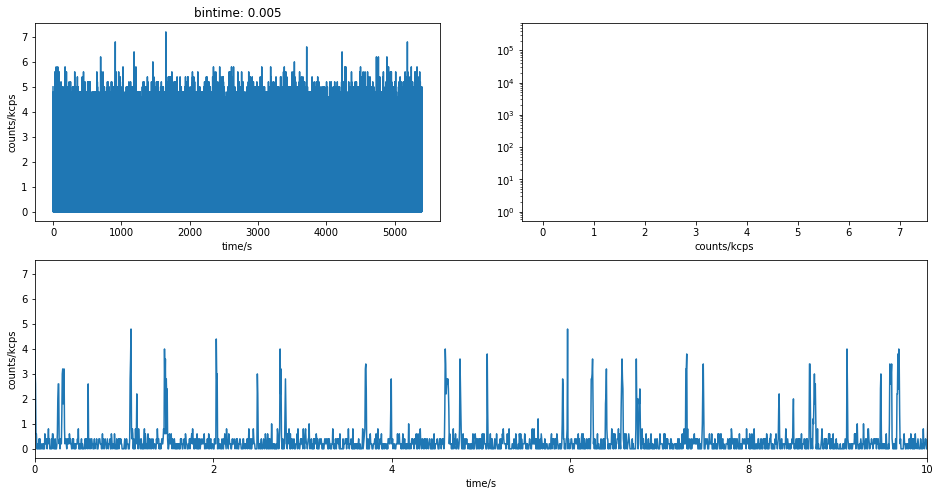

In [13]:
#input
df = timestamps;
bintime = 5e-3;#unit in seconds
#functions
tt_length=max(df)-min(df);
tt_length = round(tt_length, 0);
binpts = int(tt_length/bintime);
hist, trace = np.histogram(df, bins=binpts, range=(min(df), max(df)));
count_hist, counts = np.histogram(hist*1e-3/bintime, bins=100);
#=======plotting==========
fig = plt.figure(figsize=(16, 8));
nrows=2; ncols=2;
ax00 = plt.subplot2grid((nrows, ncols), (0,0));
ax01 = plt.subplot2grid((nrows, ncols), (0,1));
ax10 = plt.subplot2grid((nrows, ncols), (1,0), colspan=2)

ax00.plot(trace[:-1], hist*1e-3/bintime);
ax00.set_ylabel('counts/kcps')
ax00.set_xlabel('time/s')
ax00.set_title('bintime: ' + str(bintime))
ax01.bar(counts[:-1], count_hist, width=0.1)
# mu1, sig1, mu2, sig2 = two_gaussian_fit(ax01, counts[:-1], count_hist)
ax01.set_yscale('log')
ax01.set_xlabel('counts/kcps')    
# ax01.set_title('mu1: '+str(np.round(mu1, 1)) +
#               '    sig1: '+str(np.round(sig1, 1)) + '\n'
#                 'mu2: '+str(np.round(mu2, 1)) +
#               '    sig2: '+str(np.round(sig2, 1)))
ax10.plot(trace[:-1], hist*1e-3/bintime);
ax10.set_ylabel('counts/kcps')
ax10.set_xlabel('time/s')
ax10.set_xlim(0, 10)

# Changepoint analysis

## Changepoint process

In [30]:
%run changepoint_process.py
def changepoint_simulatedata(simulatedhdf5, time_sect=25, pars=[1, 0.1, 0.9, 2],
                             exp=True, rise=False, overwrite=False):
    h5 = h5py.File(simulatedhdf5, 'r+');
    if exp:
        grp_exp = 'exp_changepoint'
        if not '/'+grp_exp in h5.keys():
            grp_grp_exp = h5.create_group(grp_exp);
        timestamps_exp = h5['onexp_offexp']['timestamps'][...];
        grp_cpars = '/'+ grp_exp + '/cp_'+str(pars[1])+'_'+str(pars[2])+'_'+str(time_sect)+'s';
        if grp_cpars in h5.keys() and overwrite:
            print('exist')
            del h5[grp_cpars];
        if not grp_cpars in h5.keys() and overwrite:
            changepoint_output = changepoint_exec(timestamps_exp, simulatedhdf5, 
                                              time_sect=time_sect, pars=pars);
            h5[grp_exp][grp_cpars]=changepoint_output;
            h5[grp_exp][grp_cpars].attrs['parameters'] = pars
            h5[grp_exp][grp_cpars].attrs['time_sect'] = time_sect
            cp_cols = 'cp_index, cp_ts, cp_state, cp_countrate'
            h5[grp_exp][grp_cpars].attrs['columns'] = cp_cols
        h5.flush()
    if rise:
        grp_rise = 'rise_changepoint'
        if not '/'+grp_rise in h5.keys():
            print('doesnot exist')
            grp_grp_rise = h5.create_group(grp_rise);
        timestamps_rise = h5['onrise_offrise']['timestamps'][...];
        grp_cpars = '/'+ grp_rise + '/cp_'+str(pars[1])+'_'+str(pars[2])+'_'+str(time_sect)+'s';
        if grp_cpars in h5.keys() and overwrite:
            print('exist')
            del h5[grp_cpars];
        if not grp_cpars in h5.keys() or overwrite:
            changepoint_output = changepoint_exec(timestamps_rise, simulatedhdf5, 
                                              time_sect=time_sect, pars=pars);
            h5[grp_rise][grp_cpars]=changepoint_output;
            h5[grp_rise][grp_cpars].attrs['parameters'] = pars
            h5[grp_rise][grp_cpars].attrs['time_sect'] = time_sect
            cp_cols = 'cp_index, cp_ts, cp_state, cp_countrate'
            h5[grp_rise][grp_cpars].attrs['columns'] = cp_cols
        h5.flush()
    h5.close()
    return


In [5]:
%run changepoint_process.py
simulatedhdf5 = 'data_simulated/20171102_1638_ton0.016toff0.25timelen50.hdf5';
changepoint_simulatedata(simulatedhdf5, time_sect=25, pars=[1, 0.1, 0.9, 2],
                             exp=True, rise=False, overwrite=True)

exist


In [ ]:
simulatedhdf5 = 'data_simulated/20180111_1732_ton0.016toff0.25timelen5000bg200sig3000.hdf5';
pars_list = [[1, 0.1, 0.9, 2],
             [1, 0.01, 0.99, 2],
             [1, 0.05, 0.95, 2],
             [1, 0.1, 0.99, 2],
             [1, 0.01, 0.9, 2]
            ]
time_sect_list = [25, 50, 100]
time_cons = []
for time_sect in time_sect_list:
    for pars in pars_list:
        ti = time.time();
        changepoint_simulatedata(simulatedhdf5, time_sect=time_sect, pars=pars,
                             exp=True, rise=True, overwrite=True)
        tf = time.time();
        time_cons = np.append(time_cons, (tf-ti))
time_cons

exist
exist
exist
exist


# Changepoint vs Simulated

## Functions

In [40]:
%run changepoint_process.py
def sim_vs_changept(simulatedhdf5, pars = 'cp_0.01_0.99_25s',
                    range_on=(0, 0.1), bins_on=100,
                    range_off=(0, 0.5), bins_off=100,
                   countrate_max=5):
    h5 = h5py.File(simulatedhdf5, 'r')
    cp_outout = pd.DataFrame(h5['exp_changepoint'][pars][:],
                             columns = ['cp_index', 'cp_ts', 'cp_state', 'cp_countrate'])
    timestamps = h5['onexp_offexp']['timestamps'][...]
    t_on_sim = h5['onexp_offexp']['ontimes_exp'][...]
    t_off_sim = h5['onexp_offexp']['offtimes_exp'][...]
    h5.close()
    plt.close('all')
    fig = plt.figure(figsize=(10, 5))
    nrows=2;ncols=2;
    ax00 = plt.subplot2grid((nrows, ncols),(0,0), colspan=2)
    ax10 = plt.subplot2grid((nrows, ncols),(1,0))
    ax11 = plt.subplot2grid((nrows, ncols),(1,1))
    plot_changepoint_trace(ax00, timestamps, changepoint_output=cp_outout,
                   bintime=5e-3,
                   x_lim_min=0, y_lim_min=0, x_lim_max=10, y_lim_max=countrate_max,
                   show_changepoint=True);
    ax00.set_title(simulatedhdf5 +'\n'+pars)
    df_on, df_off = onoff_changepoint(changepoint_output=cp_outout, plotting=False)
    # on histogram
    t_on_cps = df_on['duration']#changepoint output
    n, t = np.histogram(t_on_cps, bins=bins_on, range=range_on, density=True)
    ax10.plot(t[:-1], n, label='Bright times\nChange Point')
    n, t = np.histogram(t_on_sim, bins=bins_on, range=range_on, density=True)
    ax10.plot(t[:-1], n, '.', label='Bright times\nSimulated')
    ax10.set_xlim(range_on)
    ax10.set_xlabel('duration/s')
    ax10.set_ylabel('#')
    ax10.legend()
    # off histogram
    t_off_cps = df_off['duration']
    n, t = np.histogram(t_off_cps, bins=bins_off, range=range_off, density=True)
    ax11.plot(t[:-1], n, label='Dark times\nChange Point')
    n, t = np.histogram(t_off_sim, bins=bins_off, range=range_off, density=True)
    ax11.plot(t[:-1], n, '.', label='Dark times\nSimulated')
    ax11.set_xlim(range_off)
    ax11.set_xlabel('duration/s')
    ax11.set_ylabel('#')
    ax11.legend()
    fig.tight_layout()
    return fig

## Single file-single pars

200.0


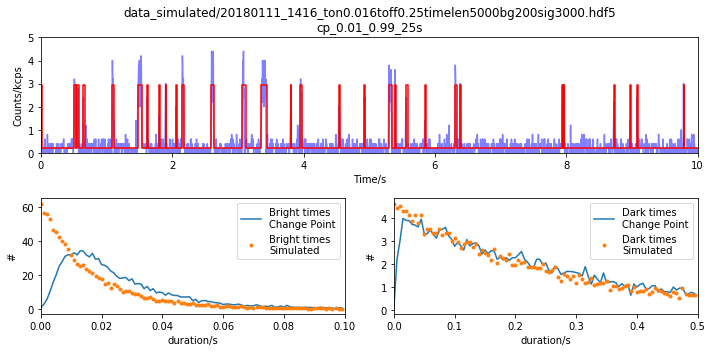

In [41]:
# %run changepoint_process.py
simulatedhdf5 = 'data_simulated/20180111_1416_ton0.016toff0.25timelen5000bg200sig3000.hdf5'
fig = sim_vs_changept(simulatedhdf5, pars='cp_0.01_0.99_25s',
                      range_on=(0, 0.1), bins_on=100,
                      range_off=(0, 0.5), bins_off=100,
                      countrate_max=5)
savename = 'data_simulated/figs_simulated/'+simulatedhdf5[15:-5]+'xyz'+'.png'
# fig.savefig(savename, dpi=300)

## Single file- all pars

data_simulated/figs_simulated/20180111_1445_ton0.016toff0.25timelen5000bg200sig20000cp_0.01_0.99_25s.png
data_simulated/figs_simulated/20180111_1445_ton0.016toff0.25timelen5000bg200sig20000cp_0.01_0.9_25s.png
data_simulated/figs_simulated/20180111_1445_ton0.016toff0.25timelen5000bg200sig20000cp_0.05_0.95_25s.png
data_simulated/figs_simulated/20180111_1445_ton0.016toff0.25timelen5000bg200sig20000cp_0.1_0.99_25s.png
data_simulated/figs_simulated/20180111_1445_ton0.016toff0.25timelen5000bg200sig20000cp_0.1_0.9_25s.png


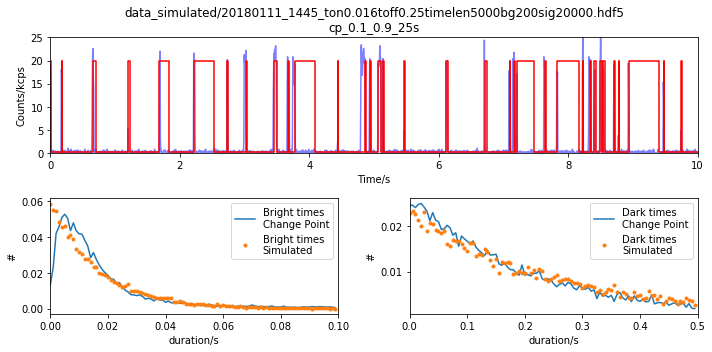

In [162]:
simulatedhdf5 = 'data_simulated/20180111_1445_ton0.016toff0.25timelen5000bg200sig20000.hdf5'
h5 = h5py.File(simulatedhdf5, 'r')
keys = h5['exp_changepoint'].keys()
for i in keys:
    fig = sim_vs_changept(simulatedhdf5, pars=i,
                      range_on=(0, 0.1), bins_on=100,
                      range_off=(0, 0.5), bins_off=100,
                         countrate_max=25)
    savename = 'data_simulated/figs_simulated/'+simulatedhdf5[15:-5]+i+'.png'
    fig.savefig(savename, dpi=300, frameon=False)
    print(savename)
h5.close()

# Simulated from Experimental data

In [5]:
def histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False):
    t_ons = []; t_offs = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(20,8))
        n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on,bins=bins_on)
        axes[0].set_xlabel(r'$\tau_{on}$')
        axes[0].set_ylabel('#')
        #axes[0].set_yscale('log')
        axes[0].set_title("ON time histogram at %s mV" %input_potential[0])
        n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off)
        axes[1].set_xlabel(r'$\tau_{off}$')
        axes[1].set_ylabel('#')
        #axes[1].set_yscale('log')
        axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
    return(t_ons, t_offs, n_on, bins_on, n_off, bins_off)

In [5]:
def hist_2d_from_t_values(t_ons, t_offs,input_potential=100, x_shift=10, bins_on=40, range_on=[0, 0.01], bins_off=50, range_off=[0, 1], plots = True):
    t_ons=pd.Series(t_ons);t_offs=pd.Series(t_offs)
    t_on_shifted_1 = t_ons.shift(+1) ## shift up
    t_on_delay_1 = pd.DataFrame([t_on_shifted_1, t_ons]); t_on_delay_1=t_on_delay_1.T
    t_on_delay_1 = t_on_delay_1.dropna();
    t_off_shifted_1 = t_offs.shift(+1) ## shift up

    t_on_shifted_x = t_ons.shift(+x_shift) ## shift up
    t_off_shifted_x = t_offs.shift(+x_shift) ## shift up
    print('Number of on events: %d' %len(t_ons))
    print('Number of off events: %d' %len(t_offs))
    if plots==True:
        import matplotlib as mpl
        colormap=mpl.cm.RdBu_r
        fig = plt.figure(figsize=(16,8))

        ax1 = fig.add_subplot(2,3,1)#2,2,1
        C_on_1,Ex_on_1,Ey_on_1, figu = hist2d(t_on_shifted_1[1:], t_ons[1:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_1,Ey_on_1 = meshgrid(Ex_on_1,Ey_on_1)
        #ax1.pcolormesh(Ex_on_1, Ey_on_1, C_on_1, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax1.set_title('ON time Cu-Azu %smV' %input_potential)
        ax1.set_xlabel(r'$\tau_{on}/s$')
        ax1.set_ylabel(r'$\tau_{on}+1/s$')

        ax2 = fig.add_subplot(2,3,2)#2,2,1
        C_on_x,Ex_on_x,Ey_on_x, figu = hist2d(t_on_shifted_x[x_shift:], t_ons[x_shift:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_x,Ey_on_x = meshgrid(Ex_on_x,Ey_on_x)
        #ax2.pcolormesh(Ex_on_x, Ey_on_x, C_on_x, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax2.set_title('ON time Cu-Azu %smV' %input_potential)
        ax2.set_xlabel(r'$\tau_{on}/s$')
        ax2.set_ylabel(r'$\tau_{on}+%s/s$'%x_shift)

        ax3 = fig.add_subplot(2,3,3)
        C_on_diff = C_on_1-C_on_x;
        pcm=ax3.pcolormesh(Ex_on_x, Ey_on_x, C_on_diff,
                       norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_on_diff.min(), vmax=C_on_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax3, extend='max')

        ax4 = fig.add_subplot(2,3,4)
        C_off_1, Ex_off_1, Ey_off_1, figu= hist2d(t_off_shifted_1[1:], t_offs[1:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_1, Ey_off_1 = meshgrid(Ex_off_1, Ey_off_1)
        colorbar()
        ax4.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax4.set_xlabel(r'$\tau_{off}/s$')
        ax4.set_ylabel(r'$\tau_{off}+1/s$')

        ax5 = fig.add_subplot(2,3,5)
        C_off_x,Ex_off_x,Ey_off_x, figu = hist2d(t_off_shifted_x[x_shift:], t_offs[x_shift:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_x,Ey_off_x = meshgrid(Ex_off_x,Ey_off_x)
        colorbar()
        ax5.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax5.set_xlabel(r'$\tau_{off}/s$')
        ax5.set_ylabel(r'$\tau_{off}+%s/s$'%x_shift)

        ax6 = fig.add_subplot(2,3,6)
        C_off_diff=C_off_1-C_off_x
        pcm=ax6.pcolormesh(Ex_off_x, Ey_off_x, C_off_diff, norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_off_diff.min(), vmax=C_off_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax6, extend='max')
        plt.tight_layout()
        return()

Generating on off times from the distribution (probability distribution function) obtained in the experiment.
Resonable paramters:
100 mV: bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1]


em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


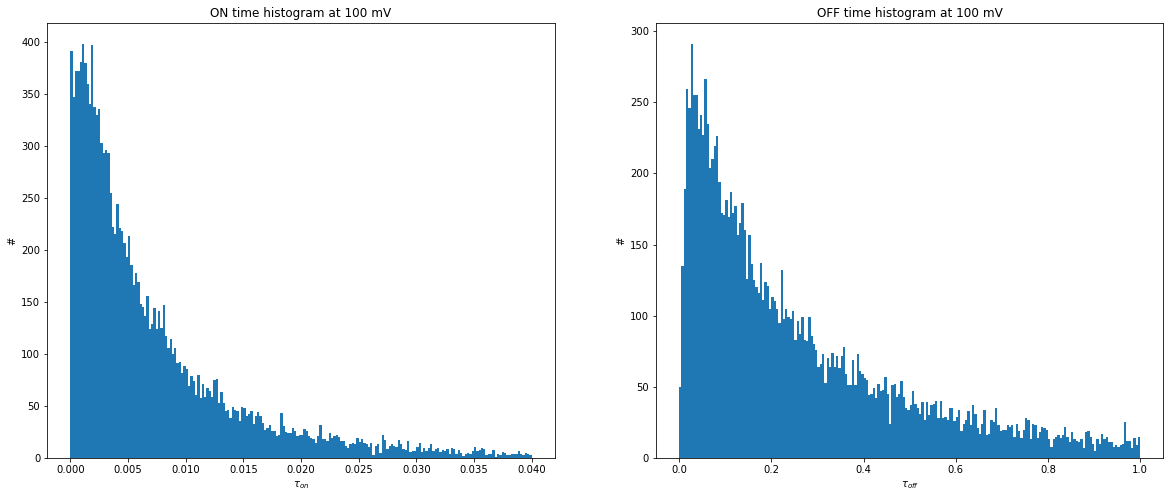

In [30]:
#
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100), 
                                        bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1], plotting=True)

prob_on = n_on/max(n_on); prob_on = prob_on/sum(prob_on);
prob_off = n_off/max(n_off); prob_off = prob_off/sum(prob_off);
data_points = 1e6
t_ons_generated = np.random.choice(bins_on[:-1], data_points, p=prob_on)
t_off_generated = np.random.choice(bins_off[:-1], data_points, p=prob_off)

Number of on events: 1000000
Number of off events: 1000000


()

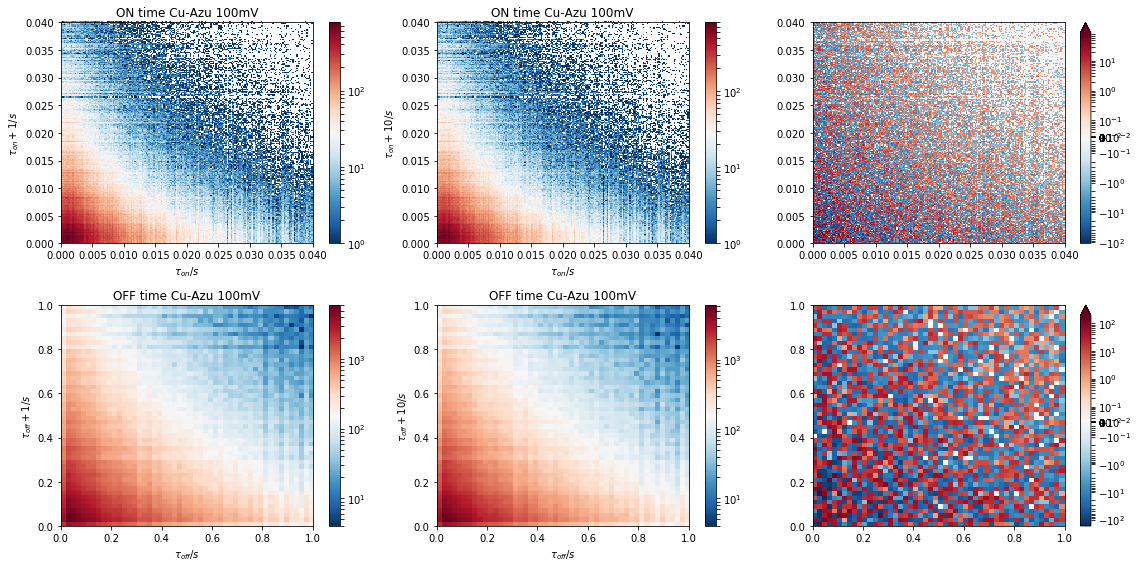

In [32]:
hist_2d_from_t_values(t_ons_generated, t_off_generated, x_shift=10, bins_on=200, range_on=[0, 0.04], bins_off=50, range_off=[0, 1], plots = True)

## Real trace: mean and var

### 0 mV

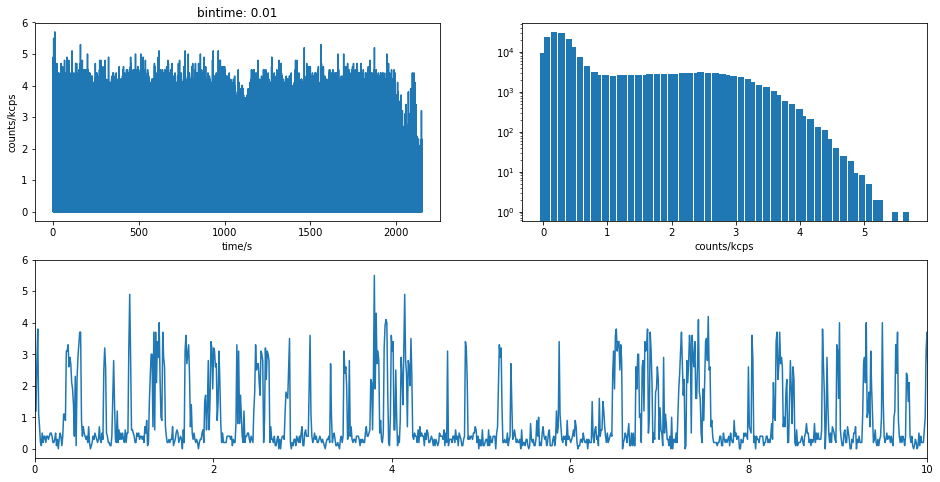

In [42]:
Point_11_0mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/\
S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A6_CuAzu655_000mV(9).pt3/data/Point_A6_000mV(9)_60.5_2160s_11.pt3.datn'
df = pd.read_csv(Point_11_0mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)

### 50 mV

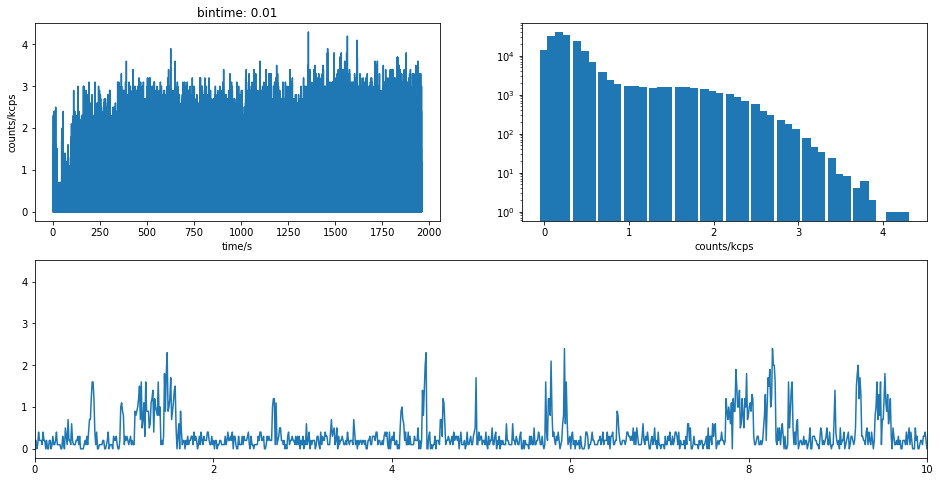

In [43]:
Point_22_50mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/\
S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A7_CuAzu655_050mV(15).pt3/data/Point_A8_050mV(15)_60.5_1980s_22.pt3.datn';
df = pd.read_csv(Point_22_50mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)

## 75 mV

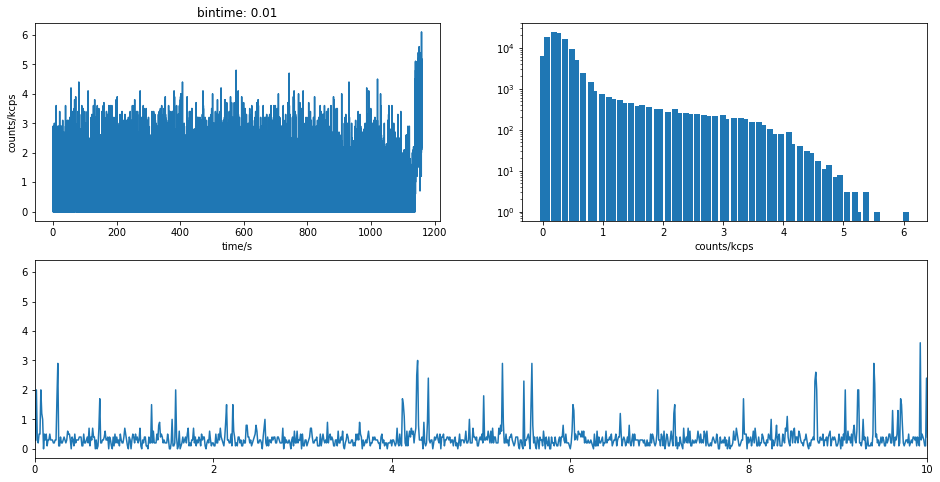

In [44]:
Point_15_75mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/\
S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A8_CuAzu655_075mV(12).pt3/data/Point_A7_075mV(12)_60.5_1160s_15.pt3.datn';
df = pd.read_csv(Point_15_75mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)

## 100 mV

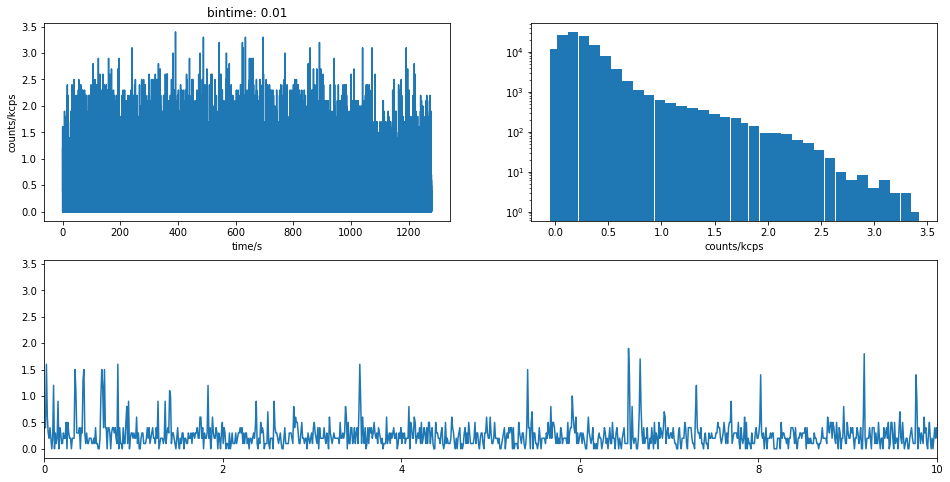

In [45]:
Point_26_100mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/\
data/S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A9_CuAzu655_100mV(18)/data/Point_A9_100mV(18)_60.5_1600s_26.pt3.datn'
df = pd.read_csv(Point_26_100mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)

# Dynamic rates

***Time traces and statistics***
<img src="../temp/Point_20_75mV_S105.svg" alt="Drawing" style="width: 600px;"/>

***Correlation***
<img src="../temp/Dynamic_corr.svg" alt="Drawing" style="width: 600px;"/>